In [79]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

import torch
import torch.nn as nn

import random

import optuna

c:\Users\hansung\anaconda3\envs\ESS_RL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")


In [5]:
fData = pd.read_csv('../../preprocessed_data/[1분 단위]아파트_동별_소비전력_전력분배_2022-07-18 00.00.00~2023-08-30 10.39.00.csv',usecols=[1,2,3,4])

fData["CONSUMPTION(kWh)"] = (fData["561_CONSUMPTION(kW)"] + fData["562_CONSUMPTION(kW)"] + fData["563_CONSUMPTION(kW)"]) / 60
fData.drop(["561_CONSUMPTION(kW)", "562_CONSUMPTION(kW)", "563_CONSUMPTION(kW)"], axis = 1, inplace =True)

fData['TIMESTAMP'] = pd.to_datetime(fData['TIMESTAMP'])

fData.set_index('TIMESTAMP', inplace=True)
fData

,CONSUMPTION(kWh)
TIMESTAMP,
2022-07-18 00:00:00,2.804928
2022-07-18 00:01:00,2.870073
2022-07-18 00:02:00,2.867803
2022-07-18 00:03:00,2.856863
2022-07-18 00:04:00,2.794600
...,...
2023-08-30 10:35:00,2.019480
2023-08-30 10:36:00,1.984963
2023-08-30 10:37:00,2.045198


In [7]:
scaler_data = MinMaxScaler()

scaler_data.fit(fData.values)

print(scaler_data.n_samples_seen_)   
print(scaler_data.data_min_)         
print(scaler_data.data_max_)  

588160
[1.10147]
[4.19295974]


[[0.55101536]
 [0.57208773]
 [0.57135345]
 ...
 [0.30526653]
 [0.30094391]
 [0.30506651]]


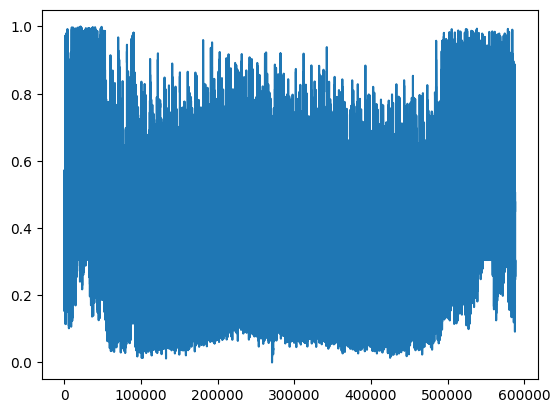

In [8]:
scaled_data = scaler_data.transform(fData.values)
print(scaled_data)
plt.plot(scaled_data)

In [9]:
scaled_df = pd.DataFrame({'timestamp' : fData.index, 'scaled_consumption' : scaled_data.flatten()})
scaled_df.set_index('timestamp', inplace=True)

scaled_df

,scaled_consumption
timestamp,
2022-07-18 00:00:00,0.551015
2022-07-18 00:01:00,0.572088
2022-07-18 00:02:00,0.571353
2022-07-18 00:03:00,0.567815
2022-07-18 00:04:00,0.547674
...,...
2023-08-30 10:35:00,0.296947
2023-08-30 10:36:00,0.285782
2023-08-30 10:37:00,0.305267


In [43]:
int(len(scaled_df) * 0.01)

648

In [ ]:
scaled_df[:int(len(scaled_df) * 0.9)]

In [83]:
scaled_df = scaled_df.loc["2022-07-18 00:00:00" : '2022-08-31 23:59:00']

train_df = scaled_df[int(len(scaled_df) * 0.9) - int(len(scaled_df) * 0.01):int(len(scaled_df) * 0.9)]
train = train_df.to_numpy()

test_df = scaled_df[int(len(scaled_df) * 0.9):int(len(scaled_df) * 0.9)+100]
test = test_df.to_numpy()

In [45]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        L = y.shape[0]
        num_samples = (L - input_window - output_window) // stride + 1

        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x].reshape([-1,])

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y].reshape([-1,])

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len


In [46]:
ow = 100
iw = ow * 2

train_dataset = windowDataset(train, input_window=iw, output_window=ow)
train_loader = DataLoader(train_dataset, batch_size=64)

In [47]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [48]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states) 
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [49]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        
        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out = out.squeeze(1)
            
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs
	
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out = out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [84]:
def train(model, train_loader, optimizer, epoch, criterion):
    model.train()
    for i in range(epoch):
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.float()
            y = y.float()
            output = model(x, y, ow, 0.6)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()

    

In [85]:
def objective(trial: optuna.Trial, X, y, train_loader):
    param = {
        'lr' : trial.suggest_float('lr', 1e-6, 1e1, log=True),
        'epoch' : trial.suggest_int('epoch', 1000, 7000, 500),
        'hidden_size' : trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    }

    model = lstm_encoder_decoder(input_size=1, hidden_size=param['hidden_size'])
    optimizer = torch.optim.Adam(model.parameters(), lr = param['lr'])
    criterion = nn.MSELoss()

    for epoch in range(1, param['epoch'] + 1):
        train(model, train_loader, optimizer, epoch, criterion)
        
    score = mean_absolute_percentage_error(X, y)
    
    return score

In [86]:
from optuna.samplers import TPESampler

# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study = optuna.create_study(direction='minimize', sampler=TPESampler())

study.optimize(lambda trial : objective(trial, train, test, train_loader), n_trials = 50)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-11-05 23:11:21,500] A new study created in memory with name: no-name-14b32dc7-17d6-41eb-8024-615905ad9847
C:\Users\hansung\AppData\Local\Temp\ipykernel_21160\3646947292.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr' : trial.suggest_loguniform('lr', 1e-6, 1e1),


In [50]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16)

In [74]:
learning_rate=0.01
epoch = 3000
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [81]:
# from tqdm import tqdm

# model.train()
# with tqdm(range(epoch)) as tr:
#     for i in tr:
#         total_loss = 0.0
#         for x,y in train_loader:
#             optimizer.zero_grad()
#             x = x.float()
#             y = y.float()
#             output = model(x, y, ow, 0.6)
#             loss = criterion(output, y)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.cpu().item()
#         tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

 10%|█         | 313/3000 [02:32<21:49,  2.05it/s, loss=6.92439]


KeyboardInterrupt: 

In [76]:
predict = model.predict(torch.tensor(train[-200:]).reshape(-1,1).float(), target_len=ow)

# predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
# real = min_max_scaler.inverse_transform(real.reshape(-1,1))

0.38380401256842406


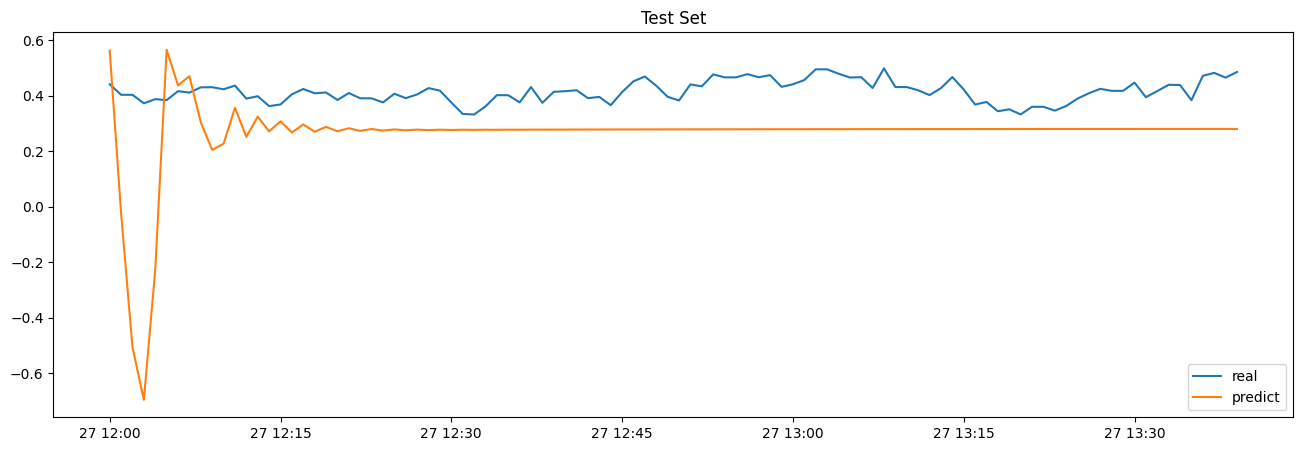

In [80]:
print(mean_absolute_percentage_error(test_df[:100].values, predict))

plt.figure(figsize=(16,5))
plt.plot(test_df[:100], label="real")
plt.plot(test_df[:100].index, predict, label="predict")

plt.title("Test Set")
plt.legend()
plt.show()